# PyQuil Learning Procedure
This is the equivalent of the notebook providing the learning procedure in Qiskit, but this substitutes the Qiskit dependencies for the Rigetti PyQuil functionalities. In the future this could also be implemeneted under the `pyquil.experiments` framework

## PyQuil imports

In [58]:
from pyquil.api import BenchmarkConnection
from pyquil import get_qc, Program
from pyquil.gates import CZ, I, H, S, MEASURE, X, CNOT, FENCE, RZ, RESET
from pyquil.paulis import PauliTerm, ID, check_commutation
from pyquil.latex import display
from pyquil.quil import Pragma

## Other Imports

In [26]:
import networkx as nx
from math import pi
from itertools import cycle, product, permutations
from random import choice
from scipy.optimize import curve_fit, nnls
import scipy as sc
import numpy as np
from itertools import combinations
from matplotlib import pyplot as plt
from collections import Counter

import warnings

warnings.simplefilter('error', sc.optimize.OptimizeWarning)

plt.style.use("ggplot")

## LearningProcedure class

In [28]:
DOUBLE_GATE = 2
SINGLE_GATE = 1
NUM_BASES = 9

class LearningProcedure:
    def __init__(self, layer, qpu):
        self.qubits = layer.get_qubits()
        self.layer = Program([inst for inst in layer if len(inst.get_qubits()) == 2])
        self.n = len(self.qubits)
        topology = qpu.qubit_topology().subgraph(self.qubits)
        self.qpu = qpu

        self.bases = self.pauli_bases(topology)
        self.model_terms = self.get_model_terms(topology)

    def pauli_bases(self, connectivity : nx.Graph):
        n = self.n
        remaining = self.qubits.copy() 

        bases = [ID()]*NUM_BASES
        while remaining:
            vertex = remaining.pop()
            #copied from Fig. S3 in van den Berg
            orderings = {"XXXYYYZZZ":"XYZXYZXYZ",
                                "XXXYYZZZY":"XYZXYZXYZ",
                                "XXYYYZZZX":"XYZXYZXYZ",
                                "XXZYYZXYZ":"XYZXZYZYX",
                                "XYZXYZXYZ":"XYZZXYYZX"}

            children = connectivity.neighbors(vertex) 
            predecessors = [c for c in children if c not in remaining]

            match len(predecessors):
                #trivial if no predecessors
                case 0:
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i] *= PauliTerm(next(cycp),vertex)
                #Choose p1:"XXXYYYZZZ" and p2:"XYZXYZXYZ" if one predecessor
                case 1:
                    pred, = predecessors
                    #store permutation of indices so that predecessor has X,X,X,Y,Y,Y,Z,Z,Z
                    bases = list(list(zip(*sorted(zip([p[pred] for p in bases], bases))))[1])
                    cycp = cycle("XYZ")
                    for i,_ in enumerate(bases):
                        bases[i] *= PauliTerm(next(cycp),vertex)
                case 2:
                    pred0,pred1 = predecessors
                    bases = list(list(zip(*sorted(zip([p[pred0] for p in bases], bases))))[1])
                    #list out string with permuted values of predecessor 2
                    substr = [p[pred0] for p in bases]
                    #match predecessor two with a permutation of example_orderings
                    reordering = ""
                    for perm in permutations("XYZ"):
                        p_substr = "".join(["XYZ"[perm.index(p)] for p in p_substr])
                        if p_substr in orderings:
                            current = orderings[p_substr] 
                            for i,p in enumerate(current):
                                bases[i] *= PauliTerm(p,vertex)
                            break
                case _: #processor needs to have connectivity so that there are <= 2 predecessors
                    raise Exception("Three or more predecessors encountered")

        print([s.pauli_string(self.qubits) for s in bases])

        return bases

    def get_model_terms(self, topology):
        model_terms = []

        #get all single-weight paulis
        for i in topology.nodes:
            for op in "XYZ":
                model_terms.append(PauliTerm(op, i))
                
        #get all weight-two paulis on with suport on nieghboring qubits
        for (q1,q2) in topology.edges:
            for op1,op2 in product("XYZ", repeat=2):
                model_terms.append(PauliTerm(op1, q1)*PauliTerm(op2,q2))

        print("The terms included in the model are the following:", [p.pauli_string(self.qubits) for p in model_terms])
        return model_terms

    def instance(
        self, 
        prep_basis, 
        meas_basis, 
        noise_repetitions : int, 
        transpiled=True
        ):

        n = self.n
        qubits = self.qubits
        bc = BenchmarkConnection()

        circ = Program(Pragma('INITIAL_REWIRING', ['"NAIVE"']))
        ro = circ.declare("ro", "BIT", self.n)
        circ += RESET()

        #get preparation ops from desired basis 
        def prep(basis, qubit):
            if basis == "X":
                return H(qubit)
            elif basis == "Y":
                return Program(H(qubit),S(qubit))
            return I(qubit)

        def meas(basis, qubit):
            if basis == "X":
                return H(qubit)
            elif basis == "Y":
                return Program(RZ(-pi/2, qubit), H(qubit))
            return I(qubit)
        
        pauli_frame = ID()

        #apply the prep and twirling operators to the circuit
        qc = Program()
        qc += [prep(b,qubit) for qubit,b in prep_basis]

        #apply repetitions of noise, including basis-change gates when needed
        for i in range(noise_repetitions):
            twirl = PauliTerm.from_list([(choice("IXYZ"),q) for q in self.qubits]) 
            qc += twirl.program

            if transpiled:
                qc = self.qpu.compiler.quil_to_native_quil(qc)
                qc.pop()
                circ += qc
                circ += self.layer
                circ += FENCE()
            else:
                circ += qc
                circ += self.layer


            qc = Program()
            pauli_frame *= twirl
            pauli_frame = bc.apply_clifford_to_pauli(self.layer, pauli_frame)

        rostring = PauliTerm.from_list([(choice("IX"),q) for q in self.qubits]) 
        qc += pauli_frame.program
        qc += [meas(b,q) for q,b in meas_basis]
        qc += rostring.program

        if transpiled:
            qc = self.qpu.compiler.quil_to_native_quil(qc)
            qc.pop()
            circ += qc
        else:
            circ += qc
        
        circ += [MEASURE(q,ro[i]) for i,q in enumerate(self.qubits)]

        return circ, {
            "prep_basis":prep_basis,
                "meas_basis":meas_basis, 
                "depth":noise_repetitions, 
                "rostring": tuple({"I":0,"X":1}[char] for char in  rostring.pauli_string(self.qubits))
            }

    def procedure(
        self,
        depths,
        samples,
        shots,
        single_samples = None,
        transpiled = True
    ):

        if isinstance(samples, int):
            samples = [samples]*len(depths)
        if not single_samples:
            single_samples = samples[0]

        self.depths = depths
        self.single_samples = single_samples
        bc = BenchmarkConnection()

        weight = lambda p : len(p)

        def conjugate(p):
            b =  bc.apply_clifford_to_pauli(self.layer, p)
            b.coefficient = 1
            return b

        #return True if Paulis differ by "I"s only
        def disjoint(pauli1, pauli2):
            c = Counter()
            for q in pauli1.operations_as_set().union(pauli2.operations_as_set()):
                c[q[0]] += 1
            return all([c[q] == 1 for q in c.keys()])

        #return True if pauli requires a degeracy lifting measurement based on the conditions described above
        def is_single(pauli):
            pair = conjugate(pauli)
            return (pauli in self.model_terms and pair in self.model_terms) and pauli != pair

        #find disjoint operators that can be measured simultaneously to find six bases
        pairs = set([frozenset([p,conjugate(p)]) for p in self.model_terms if is_single(p)])
        print(pairs)
        single_bases = []
        for p1,p2 in pairs:
            for i,pauli in enumerate(single_bases):
                if disjoint(pauli, p1) and disjoint(pauli, p2):
                    single_bases[i] = pauli.compose(p2)
                    break
            else:
                single_bases.append(p2)

        print("bases for singles: ",single_bases)

        SINGLE = 1
        circuits = []
        metadatas = []
        bases = self.bases
        total = len(bases)*sum(samples)+len(single_bases)*single_samples

        j=0
        for basis, (d,s) in product(bases, zip(depths,samples)):
            for i in range(s):
                circ, data = self.instance(basis, basis, d, transpiled)
                data["type"] = "double"
                circuits.append(circ)
                metadatas.append(data)
                j+=1
                print(j,"/",total, end='\r')

        for basis, s in product(single_bases, range(single_samples)):
            circ,data = self.instance(conjugate(basis),basis,SINGLE, transpiled)
            data["type"] = "single"
            circuits.append(circ)
            metadatas.append(data)
            j+=1
            print(j,"/",total, end='\r')
        
        print("Generated",len(circuits), "circuits")
        return circuits, metadatas
    
  

## Input Data
The input data for the learning procedure is a quantum computer backend and a circuit representing a layer of the full circuit including or excluding the single-qubit gates.

In [29]:
qpu = get_qc("2q-qvm", noisy=True)
layer = Program(CZ(0,1))
tglp = LearningProcedure(layer, qpu)

['XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']
The terms included in the model are the following: ['XI', 'YI', 'ZI', 'IX', 'IY', 'IZ', 'XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']


## Generate Circuits

In [32]:
circuits, metadatas = tglp.procedure([2,4,16, 32], 50, 50, transpiled=False)

{frozenset({(1+0j)*X0*X1, 1*Y0*Y1}), frozenset({(1+0j)*X1, 1*Z0*X1}), frozenset({(1+0j)*Y0, 1*Y0*Z1}), frozenset({1*Y0*X1, (1+0j)*X0*Y1}), frozenset({(1+0j)*X0, 1*X0*Z1}), frozenset({1*Z0*Y1, (1+0j)*Y1})}
bases for singles:  [1*Y0*Y1, 1*Z0*X1, 1*Y0*Z1, (1+0j)*X0*Y1, 1*X0*Z1, (1+0j)*Y1]
Generated 2100 circuits


## Collect Results
This code is a clunky way to collect results as a counter. If there is a more PyQuil-like way to implement this it should be done. In addition, parallelization will be necessary when running on an actual qpu.

In [33]:
results = []
from collections import Counter
for i,circ in enumerate(circuits):
    print(i, end='\r')
    exe = qpu.compiler.native_quil_to_executable(circ)
    res = qpu.run(exe).readout_data['ro']
    l = [tuple(r) for r in res]
    results.append(Counter(l))

## ProcedureAnalysis class
This is the part of the protocol which processes the resutls of running the circuits.

In [34]:
class ProcedureAnalysis:
    def __init__(self, layer, depths, single_samples, model_terms):
        self.qubits = layer.get_qubits()
        self.layer = Program([inst for inst in layer if len(inst.get_qubits()) == 2])
        self.n = len(layer.get_qubits())
        self.single_samples = single_samples
        self.depths = depths
        self.model_terms = model_terms

    @classmethod
    def fromExperiment(cls, experiment):
        return cls(
            experiment.layer,
            experiment.depths,
            experiment.single_samples,
            experiment.model_terms
        )

    def get_expectation(self, measurement, **metadata):
        total = 0
        counts = metadata['counts']
        pauli_weight = [{"I":0}.get(p,1) for p in measurement.pauli_string(self.qubits)]
        rostring = metadata['rostring']
        for key in counts.keys():
            ro_adjusted = np.bitwise_xor(key, rostring)
            sgn = np.dot(pauli_weight, ro_adjusted)
            total += (-1)**sgn*counts[key]
        return total/sum(counts.values())

    def get_noise_model(self, basis_dict):
        bc = BenchmarkConnection()

        def conjugate(p):
            b =  bc.apply_clifford_to_pauli(self.layer, p)
            b.coefficient = 1
            return b
  
        F1 = []
        F2 = []
        fidelities = []
        for key in self.model_terms:
            F1.append(key)
            fidelities.append(basis_dict[key]['fidelity'])
            if basis_dict[key]["type"] == "pair":
                pair = conjugate(key)
                F2.append(pair)
            else:
                F2.append(key)

        sprod = lambda a,b: int(not check_commutation([a],b))
        M1 = [[sprod(a,b) for a in self.model_terms] for b in F1]
        M2 = [[sprod(a,b) for a in self.model_terms] for b in F2]
        if np.linalg.matrix_rank(np.add(M1,M2)) != len(self.model_terms):
            raise Exception("Matrix is not full rank, something went wrong!")

        coeffs,rnorm = nnls(np.add(M1,M2), -np.log(fidelities))

        noise_model = list(zip(coeffs, self.model_terms))

        print("Noise model reconstructed with r-norm", rnorm)

        return noise_model
        
    def analyze(self, results, metadatas):

        bc = BenchmarkConnection()

        def conjugate(p):
            b =  bc.apply_clifford_to_pauli(self.layer, p)
            b.coefficient = 1
            return b
            
        def simultaneous(pauli1, pauli2):
            c = Counter()
            for q in pauli1.operations_as_set().union(pauli2.operations_as_set()):
                c[q[0]] += 1
            return all([c[q] == 1 for q in c.keys()])

        def is_single(pauli):
            pair = conjugate(pauli)
            return (pauli in self.model_terms and pair in self.model_terms) and pauli != pair

        def sim_meas(pauli):
            return [term for term in self.model_terms if simultaneous(pauli, term)]

        def all_sim_meas(pauli):
            return [PauliTerm.from_list([tuple(reversed(p)) for p in l]) 
            for n in range(1, len(pauli)+1) for l in combinations(pauli,n)]

        depths = self.depths
        single_samples = self.single_samples

        for res,data in zip(results, metadatas):
            data["counts"] = res

        singles = []
        doubles = []
        for datum in metadatas:
            type = datum["type"]
            if type == "single":
                singles.append(datum)
            elif type == "double":
                doubles.append(datum)

        #reorder by measurement basis
        basis_dict = {}
        self.ordered_data = basis_dict
        #improve execution time by storing runs of all_sim_meas for each basis
        sim_measurements = {}
        for datum in doubles:
            #get run data
            basis = datum['prep_basis']
            depth = datum['depth']
            #find simultaneous measurements
            if not basis in sim_measurements:
                sim_measurements[basis] = all_sim_meas(basis)
            #aggregate expectation value data for each simultaneous measurement
            for pauli in sim_measurements[basis]:
                expectation = self.get_expectation(pauli, **datum)
                #set up dictionary
                if not pauli in basis_dict:
                    basis_dict[pauli] = {"expectation":[0 for d in depths], "total":[0 for d in depths]}
                #add expectation value to result at depth
                basis_dict[pauli]["expectation"][depths.index(depth)] += expectation
                basis_dict[pauli]["total"][depths.index(depth)] += 1        

        expfit = lambda x,a,b : a*np.exp(x*-b)
        #for each of the simultaneous measurements
        for key in basis_dict.keys():
            for i,d in enumerate(depths):
                #divide by total
                basis_dict[key]["expectation"][i] /= basis_dict[key]["total"][i]
            #try finding exponential fit, default to ideal if no fit found
            try:
                popt, pcov = curve_fit(expfit, depths, basis_dict[key]["expectation"], p0=[.9,.01])
            except:
                popt = 1,0

            #store fidelity and SPAM coefficients
            basis_dict[key]["fidelity"] = expfit(1,1,popt[1])
            basis_dict[key]["SPAM"] = popt[0]

            #record whether measurement appears as a pair or as a single fidelity
            if key != conjugate(key):
                basis_dict[key]["type"] = "pair"
            else:
                basis_dict[key]["type"] = "single"
        
        singles_dict = {} #store results of single measurements
        sim_measurements = {}
        for datum in singles:
            meas_basis = datum['meas_basis']
            prep_basis = datum['prep_basis']
            #find terms that can be measured simultaneously
            if not meas_basis in sim_measurements:
                sim_measurements[meas_basis] = []
                for term in self.model_terms:
                    if simultaneous(meas_basis, term) and simultaneous(prep_basis, conjugate(term)) and is_single(term):
                        sim_measurements[meas_basis].append(term)

            for meas in sim_measurements[meas_basis]:
                if meas not in singles_dict:
                    singles_dict[meas] = 0
                expectation = self.get_expectation(meas, **datum)
                #the measurement basis SPAM coefficients are closer because the readout noise, combined
                #with the noise from the last layer, is greater than the state preparation noise
                fidelity = np.min([1.0,np.abs(expectation)/basis_dict[meas]["SPAM"]])
                singles_dict[meas] += fidelity/single_samples

        #add singles data to basis_dict
        for key in singles_dict.keys():
            basis_dict[key]['fidelity'] = singles_dict[key]
            basis_dict[key]['type'] = "single"
        
        #fit model 
        self.noise_model = self.get_noise_model(basis_dict)
        for coeff, pauli in self.noise_model:
            basis_dict[pauli]["coefficient"] = coeff

        return basis_dict
    
    #graph a subset of the measured expectation values and plot fits
    def graph(self,*paulis):
        expfit = lambda x,a,b : a*np.exp(x*-b)
        colcy = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:cyan", "tab:brown", "tab:pink", "tab:gray", "tab:olive"])
        for p in paulis:
            c = next(colcy)
            data = self.ordered_data[p]['expectation']
            try:
                popt, pcov = curve_fit(expfit, self.depths, data, p0=[.9,.01])
            except:
                popt = 1,0 
            xrange = np.linspace(0,np.max(self.depths))
            plt.plot(xrange, [expfit(x, *popt) for x in xrange], color=c)
            plt.plot(self.depths, data, color = c, marker="o", linestyle = 'None')
        plt.title("Expectation vs Depth")
        plt.xlabel("Depth")
        plt.ylabel("Fidelity")
        plt.show()

    #display the measured fidelities plotted against the ideal fidelitites
    def display(self,*paulis, factor = 10):
        bc = BenchmarkConnection()
        def conjugate(p):
            b =  bc.apply_clifford_to_pauli(self.layer, p)
            b.coefficient = 1
            return b
        basis_dict = self.ordered_data 
        ax = np.arange(len(paulis))
        fidelities = []
        for p in paulis:
            fid = basis_dict[p]['fidelity']
            if(basis_dict[p]['type'] == 'pair'):
                pair = conjugate(p)
                fid = fid**2/basis_dict[pair]['fidelity']
            fidelities.append(fid)
        plt.bar(ax, [10*(1-f) for f in fidelities],color='tab:blue')
        plt.xticks(ax, [p.pauli_string(self.qubits) for p in paulis])
        plt.title("Measured Fidelitites")
        plt.xlabel("Term")
        plt.ylabel(str(factor)+" x (1-f)")
        plt.legend(["Measured", "Ideal"])
        plt.show()

    def display_model(self, *paulis, labels = None):
        if not labels:
            labels = [p.pauli_string(self.qubits) for p in paulis]
        ax = np.arange(len(paulis))
        coeffs,_ = zip(*self.noise_model)
        plt.bar(ax, coeffs, color='tab:blue')
        plt.xticks(ax, labels);
        plt.title("Computed vs Measured Model Terms")
        plt.xlabel("Term")
        plt.ylabel("Coefficient")
        plt.show()

Create analysis class corresponding to experiment

In [35]:
analysis = ProcedureAnalysis.fromExperiment(tglp)

## Process Results
The circuits have been compared manually to those simulated in Qiskit, and here the same number of shots and depths which produced clearly exponential fidelity curves are simulated. It is unclear why the result is different in the PyQuil simulator, but hopefully since the circuits appear to be correct this is just an issue with the simulator.

In [56]:
analysis.analyze(results, metadatas);

Noise model reconstructed with r-norm 0.013022950007692078


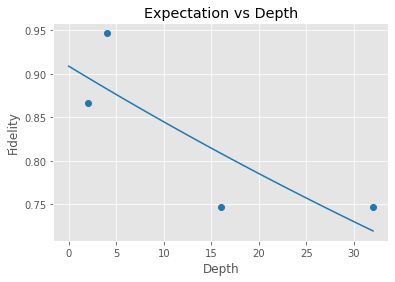

In [57]:
analysis.graph(analysis.model_terms[0])